### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, dot, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Read Data

In [4]:
data = pd.read_csv(r"D:\projects\Abstactive Text Summarization\archive\data.csv")

# Read the first 10,000 rows  beacuse its a amassive data
# data = pd.read_csv(r"D:\projects\Abstactive Text Summarization\archive\data.csv", nrows=10000)

In [5]:
df = data.copy()

In [6]:
# Count of missing values per column
df.isnull().sum()

Unnamed: 0        0
ID            56216
Content          34
Summary           0
Dataset           0
dtype: int64

In [7]:
# Delete rows where Content is NaN
df = df.dropna(subset=['Content'])

In [8]:
# Reset index after deletion
df.reset_index(drop=True, inplace=True)

In [9]:
print(df.isnull().sum())

Unnamed: 0        0
ID            56216
Content           0
Summary           0
Dataset           0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870487 entries, 0 to 870486
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  870487 non-null  int64 
 1   ID          814271 non-null  object
 2   Content     870487 non-null  object
 3   Summary     870487 non-null  object
 4   Dataset     870487 non-null  object
dtypes: int64(1), object(4)
memory usage: 33.2+ MB


### dropping duplicates

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.columns

Index(['Unnamed: 0', 'ID', 'Content', 'Summary', 'Dataset'], dtype='object')

In [13]:
df.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [14]:
df = df.drop(["Unnamed: 0","ID","Dataset"],axis=1)

In [15]:
df.head()

,Content,Summary
0,New York police are concerned drones could bec...,Police have investigated criminals who have ri...
1,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...
2,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...
3,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...
4,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...


### Data Preparation

In [16]:
import re
import unicodedata
import contractions
import logging
from nltk.corpus import stopwords

# Initialize logging to capture any warnings
logging.basicConfig(level=logging.WARNING)

# Load English stopwords from NLTK library
stop_words = set(stopwords.words('english'))

def text_cleaner(text, num):
    
    newString = text.lower()

    # Remove any content within parentheses 
    newString = re.sub(r'\([^)]*\)', '', newString)

    # Remove double quotes from the text
    newString = re.sub('"', '', newString)

    # Expand contractions 
    newString = contractions.fix(newString)

    # Remove possessive 's 
    newString = re.sub(r"'s\b", "", newString)

    # Normalize unicode characters to their closest ASCII equivalent
    newString = unicodedata.normalize('NFKD', newString).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove URLs 
    newString = re.sub(r'https?://\S+|www\.\S+', '', newString)

    # Remove non-alphabetical characters
    newString = re.sub("[^a-zA-Z]", " ", newString)

    # Normalize repeated characters
    newString = re.sub(r'(.)\1{2,}', r'\1\1', newString)

    # Remove newlines and excessive spaces
    newString = re.sub(r'\s+', ' ', newString).strip()

    # Split the text into tokens (words)
    tokens = newString.split()

    # remove stopwords from the tokens list
    if num == 0:
        tokens = [w for w in tokens if w not in stop_words]

    # Keep words with more than one character, but keep "a" and "i"
    long_words = [w for w in tokens if len(w) > 1 or w in ['a', 'i']]

    # Return the cleaned text as a space-separated string
    return ' '.join(long_words)


In [17]:
 # Clean the text using the 'text_cleaner' function and append the cleaned text to the list
cleaned_text = []
for t in df['Content']:
    cleaned_text.append(text_cleaner(t,0))

In [19]:
cleaned_text[:5]

In [20]:
 # Clean the summary using the 'text_cleaner' function and append the cleaned summary to the list
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [21]:
cleaned_summary[:10]

In [22]:
# Assign the cleaned content to a new column called 'cleaned_text'
df['cleaned_text'] = cleaned_text

# Assign the cleaned summaries to a new column called 'cleaned_summary'
df['cleaned_summary'] = cleaned_summary

In [23]:
# Replace any empty strings in the DataFrame with NaN (missing values)
df.replace('', np.nan, inplace=True)

# Drop all rows where any column contains a NaN value (i.e., remove incomplete data)
df.dropna(axis=0, inplace=True)

In [18]:
df.head()

,Content,Summary,cleaned_text,cleaned_summary
0,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,new york police concerned drones could become ...,police have investigated criminals who have ri...
1,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,ryan lipman perhaps australian porn star angel...,porn star angela white secretly filmed sex act...
2,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,sergio garcia conceded much like hunted tiger ...,american draws inspiration from fellow country...
3,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,ebola outbreak began guinea four months ago tu...,world health organisation infections and death...
4,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,associated press daily mail reporter published...,sinkhole opened up at am this morning in duned...


In [24]:
# Create a new DataFrame with only the cleaned_text and cleaned_summary columns
new_df = df[['cleaned_text', 'cleaned_summary']]

new_df.columns = ['text', 'summary']

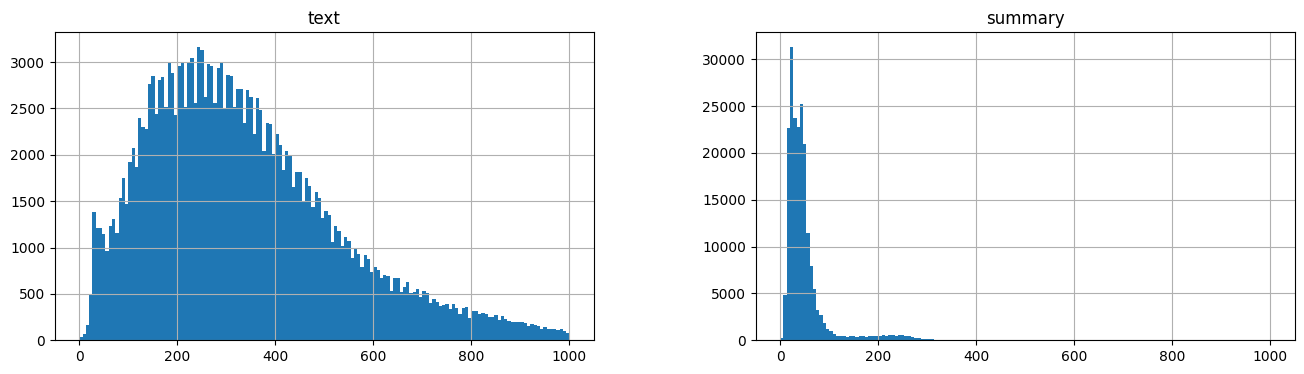

In [20]:
# Plot histograms to visualize the distribution of word counts
# This helps in understanding how long most of the texts and summaries are
# Useful for setting max length limits for input and output during training
text_count = [len(sentence.split()) for sentence in new_df.text]
headlines_count = [len(sentence.split()) for sentence in new_df.summary]

pd.DataFrame({
    'text': text_count,
    'summary': headlines_count
}).hist(bins=150, figsize=(16, 4), range=[0, 1000])

plt.show()

In [21]:
# percentage of length of words
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of summary have 0-220 words
print(get_word_percent(new_df.summary, 230))

# Check how many % of text have 0-1000 words
print(get_word_percent(new_df.text, 1000))

0.98
0.98


In [22]:
# Set maximum sequence lengths based on distribution analysis
max_text_len=1000
max_summary_len=230

In [23]:
cleaned_text = np.array(new_df['text'])
cleaned_summary = np.array(new_df['summary'])

text = []
summary = []

# Filter out texts and summaries that exceed maximum length constraints
for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and 100 <= len(cleaned_text[i].split()) <= max_text_len):
        text.append(cleaned_text[i])
        summary.append(cleaned_summary[i])

new_df = pd.DataFrame({'text':text,'summary':summary})


In [25]:
# Add special tokens to the beginning and end of each summary
new_df['summary'] = new_df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [26]:
# Split the dataset into training and validation sets (90% train, 10% validation)
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(new_df['text']), 
    np.array(new_df['summary']), 
    test_size=0.1, 
    random_state=0, 
    shuffle=True
)

In [ ]:
import pickle

with open('C:/Users/LEGION/Desktop/Abstactive Text Summarization/x_tokenizer.pkl', 'rb') as f:
    x_tokenizer = pickle.load(f)

with open('C:/Users/LEGION/Desktop/Abstactive Text Summarization/y_tokenizer.pkl', 'rb') as f:
    y_tokenizer = pickle.load(f)


In [27]:
# Initialize a tokenizer for the input text
# The tokenizer will learn the word-to-index mapping based on training data

# x_tokenizer = Tokenizer()
# x_tokenizer.fit_on_texts(list(x_tr))

In [28]:
thresh = 20# Frequency threshold to consider a word as rare

cnt = 0        # Number of rare words (appeared less than threshold)
tot_cnt = 0    # Total number of unique words
freq = 0       # Total frequency of rare words
tot_freq = 0   # Total frequency of all words

# Loop through word counts in tokenizer
for key, value in x_tokenizer.word_counts.items():
    tot_cnt += 1
    tot_freq += value
    if value < thresh:
        cnt += 1
        freq += value

# Print percentage of rare words in vocabulary
print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)

# Print how much those rare words contribute to total word frequency
print("Total Coverage of rare words:", (freq / tot_freq) * 100)


% of rare words in vocabulary: 92.89319720087185
Total Coverage of rare words: 5.643620052967783


In [29]:
#prepare a tokenizer for reviews on training data

# x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
# x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [30]:
x_voc

23542

In [31]:
# y_tokenizer = Tokenizer()
# y_tokenizer.fit_on_texts(list(y_tr))

In [32]:
thresh=30

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 86.89130120656023
Total Coverage of rare words: 5.431840000042537


In [33]:
#prepare a tokenizer for summaries on training data

# y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
# y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words + 1

In [34]:
# Check how many times the special token 'sostok' appears, and total training samples
y_tokenizer.word_counts['sostok'],len(y_tr)

(160074, 160074)

In [ ]:
# import pickle

# with open('C:/Users/LEGION/Desktop/Abstactive Text Summarization/x_tokenizer.pkl', 'wb') as f:
#     pickle.dump(x_tokenizer, f)

# with open('C:/Users/LEGION/Desktop/Abstactive Text Summarization/y_tokenizer.pkl', 'wb') as f:
#     pickle.dump(y_tokenizer, f)


In [35]:
# deleting the rows that contain only **START** and **END** tokens

ind=[]

for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [36]:
ind=[]

for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [37]:
from keras import backend as K

K.clear_session()

# Increase latent dimensions
latent_dim = 512  # Increased number of neurons
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM Layers (stacked)
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm1')
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm2')
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm3')
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)

# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM Layers (stacked)
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm1')
decoder_outputs1, decoder_state_h1, decoder_state_c1 = decoder_lstm1(dec_emb, initial_state=[state_h1, state_c1])

decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm2')
decoder_outputs2, decoder_state_h2, decoder_state_c2 = decoder_lstm2(decoder_outputs1, initial_state=[state_h2, state_c2])

decoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm3')
decoder_outputs3, decoder_state_h3, decoder_state_c3 = decoder_lstm3(decoder_outputs2, initial_state=[state_h3, state_c3])

# Attention Mechanism
# Compute the attention scores
attention = dot([decoder_outputs3, encoder_outputs3], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

# Compute the context vector
context = dot([attention, encoder_outputs3], axes=[2, 1])

# Concatenate context vector and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs3, context])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 300)    7062600     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    4354800     ['input_2[0][0]']                
                                                                                              

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

In [42]:
assert not np.any(np.isnan(x_tr))
assert not np.any(np.isnan(y_tr))
assert not np.any(np.isnan(x_val))
assert not np.any(np.isnan(y_val))

In [43]:
history=model.fit([x_tr,y_tr[:,:-1]],y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=15,
                  callbacks=[es, reduce_lr],
                  batch_size=30,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/15
5336/5336 [==============================] - 2544s 475ms/step - loss: 1.2111 - accuracy: 0.8333 - val_loss: 1.1283 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 2/15
5336/5336 [==============================] - 2536s 475ms/step - loss: 1.0843 - accuracy: 0.8424 - val_loss: 1.0639 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 3/15
5336/5336 [==============================] - 2529s 474ms/step - loss: 1.0325 - accuracy: 0.8461 - val_loss: 1.0314 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 4/15
5336/5336 [==============================] - 2736s 513ms/step - loss: 1.0157 - accuracy: 0.8479 - val_loss: 1.0184 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 5/15
5336/5336 [==============================] - 2535s 475ms/step - loss: 0.9911 - accuracy: 0.8494 - val_loss: 1.0002 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 6/15
5336/5336 [==============================] - 2541s 476ms/step - loss: 0.9747 - accuracy: 0.8506 - val_loss: 0.9819 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 7/15
5336/5336 [======

In [45]:
model.save("text_summarization_model_5.h5")

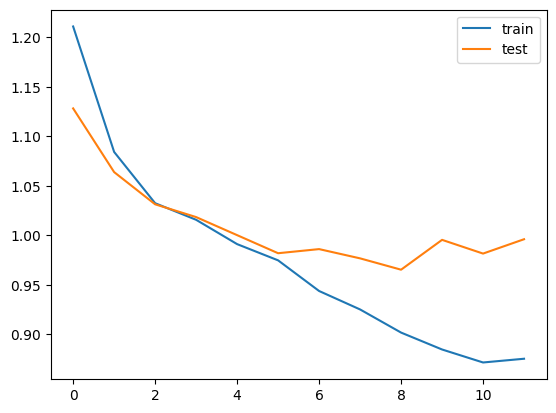

In [46]:
# Plot training and validation loss over epochs to evaluate model performance
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
# Create dictionaries to map token indices back to words
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [48]:
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Activation, dot, Concatenate
from keras.models import Model

# Encoder Model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs3, state_h1, state_c1, state_h2, state_c2, state_h3, state_c3])

# Decoder setup for inference
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_state_input_h3 = Input(shape=(latent_dim,))
decoder_state_input_c3 = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# Set the initial states to the states from the previous time step
decoder_outputs1, state_h1_inf, state_c1_inf = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h1, decoder_state_input_c1])
decoder_outputs2, state_h2_inf, state_c2_inf = decoder_lstm2(decoder_outputs1, initial_state=[decoder_state_input_h2, decoder_state_input_c2])
decoder_outputs3, state_h3_inf, state_c3_inf = decoder_lstm3(decoder_outputs2, initial_state=[decoder_state_input_h3, decoder_state_input_c3])

# Attention inference
attention_inf = dot([decoder_outputs3, decoder_hidden_state_input], axes=[2, 2])
attention_inf = Activation('softmax', name='attention')(attention_inf)

# Compute the context vector
context_inf = dot([attention_inf, decoder_hidden_state_input], axes=[2, 1])

# Concatenate context vector and decoder LSTM output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs3, context_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_final = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h1, decoder_state_input_c1, decoder_state_input_h2, decoder_state_input_c2, decoder_state_input_h3, decoder_state_input_c3],
    [decoder_outputs_final, state_h1_inf, state_c1_inf, state_h2_inf, state_c2_inf, state_h3_inf, state_c3_inf]
)

decoder_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    4354800     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h1, e_c1, e_h2, e_c2, e_h3, e_c3 = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h1, c1, h2, c2, h3, c3 = decoder_model.predict(
            [target_seq] + [e_out, e_h1, e_c1, e_h2, e_c2, e_h3, e_c3]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h1, e_c1 = h1, c1
        e_h2, e_c2 = h2, c2
        e_h3, e_c3 = h3, c3

    return decoded_sentence

In [52]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [53]:
for i in range(0,5):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: start donald trump built campaign prejudice paranoia said taking hate groups mainstream helping radical fringe take republican party disregard values make country great profoundly dangerous minute speech largely mr trump controversial statements actions years mexican judge comments gonzalo questioning barack obama birth status campaign ties right movement justice department lawsuit accused refusing rent apartments minorities mrs clinton also took characterised opponent temperament worry say president trump surrounded smart advisers rein worst said tweet gets skin wants retaliate cruise missile maybe cooler heads convince criticisms made june speech targeted republican foreign policy views prompting angry response mr trump thursday speech different watched speech mr trump tweeted short lies one fear campaign also released statements several political advisers business associates denouncing mrs clinton speech today proved american public known along hillary clinton hope vision id

In [54]:
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to evaluate ROUGE scores for the model's predictions
def evaluate_rouge(predictions, references):
    rouge1 = []
    rouge2 = []
    rougeL = []
    
    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)
    
    avg_rouge1 = np.mean(rouge1)
    avg_rouge2 = np.mean(rouge2)
    avg_rougeL = np.mean(rougeL)
    
    return avg_rouge1, avg_rouge2, avg_rougeL

# Generate predictions for the validation set
predictions = []
references = []

for i in range(20):
    predicted_summary = decode_sequence(x_val[i].reshape(1, max_text_len))
    predictions.append(predicted_summary)
    references.append(seq2summary(y_val[i]))

# Calculate ROUGE scores
avg_rouge1, avg_rouge2, avg_rougeL = evaluate_rouge(predictions, references)

print(f"ROUGE-1 F1 Score: {avg_rouge1}")
print(f"ROUGE-2 F1 Score: {avg_rouge2}")
print(f"ROUGE-L F1 Score: {avg_rougeL}")

1/1 [==============================] - 0s 25ms/step
ROUGE-1 F1 Score: 0.16463264866964206
ROUGE-2 F1 Score: 0.02029178428743841
ROUGE-L F1 Score: 0.12757747268124692


### Evaluation Results Summary:

##### The model achieved a ROUGE-1 F1 score of ~16.46%, indicating that around 16% of the unigrams (individual words) in the reference summaries were successfully captured by the generated summaries. The ROUGE-2 F1 score is ~2.03%, reflecting a low overlap of bigrams (word pairs), which suggests limited fluency and coherence in the predictions. The ROUGE-L F1 score of ~12.75% shows a moderate ability of the model to capture the longest common subsequences, meaning the structure of the summaries is partially aligned with the references.

##### These results indicate that the model is learning basic summary content but still requires improvement in capturing phrase-level meaning and structure.